In [1]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd

%load_ext autoreload
%autoreload 2

## Jan Temp Quantiles
---
Load data and interpolate the design value field

In [14]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/jan1.0p/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan1.0p.nc'
mask_path = '/home/nannau/Desktop/climpyrical/data/mask.nc'
dv = 'tas'

interp_dict = get_ieof(mask_path, PATH, dv)
master_idx = interp_dict['idx']
vT = (interp_dict['iens'][:, master_idx])
# interp_dict['ens'][interp_dict['idx_ni']]

In [3]:
iens:
from minisom import MiniSom

w = 10
h = 10
som = MiniSom(h, w, len(data[0]), learning_rate=0.5,
              sigma=3, neighborhood_function='triangle')

som.train_random(data, 2500, verbose=True)
win_map = som.win_map(data)


array([[  7.67210362,   7.55653735,   7.44097107, ..., -39.89171847,
        -39.28120599, -38.67069351],
       [  7.30845084,   7.2078072 ,   7.10716356, ..., -40.87806801,
        -40.29505049, -39.71203298],
       [  7.0814527 ,   6.97899376,   6.87653481, ..., -39.58981957,
        -38.84992186, -38.11002415],
       ...,
       [  7.10029224,   7.00557469,   6.91085715, ..., -40.40472859,
        -39.65959646, -38.91446434],
       [  7.66237899,   7.55007027,   7.43776154, ..., -39.37654915,
        -38.69539357, -38.01423799],
       [  7.67221527,   7.55752742,   7.44283957, ..., -40.10913353,
        -39.48688506, -38.8646366 ]])

In [29]:
# u, s, vT = np.linalg.svd(interp_dict['ens'][:, interp_dict['idx_ni']], full_matrices=False)
# ens_eof = interp_dict['ens']
# ens_eof[:, interp_dict['idx_ni']] = vT
# sp_eof = ens_eof.reshape((interp_dict['ens'].shape[0], interp_dict['rlat'].shape[0], interp_dict['rlon'].shape[0]))
# sp_eof

Plot distribution.

Text(0.5, 1.0, 'KDE Distribution of tas Values')

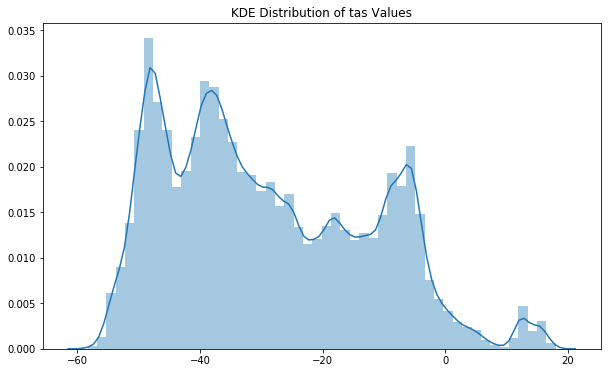

In [30]:
plt.figure(figsize=(10, 6))
sns.distplot(iens[0, ...])
plt.title('KDE Distribution of {} Values'.format(dv))

Perform singular value decomposition

In [4]:
# u, s, vT = np.linalg.svd(iens, full_matrices=False)
# del u

Calculate explained variance and plot

In [5]:
explained_variance_ratio = [s[i]/np.sum(s) for i in range(s.shape[0])]
cumulative_variance = np.cumsum(explained_variance_ratio)
component = range(s.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(component, explained_variance_ratio)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')

NameError: name 's' is not defined

Load the quantile station data

In [6]:
df = pd.read_csv('/home/nannau/Desktop/climpyrical/data/jan_1st_percentile_1991_2016', index_col=None)
# df = df[df['completeness'] > 0.8]

In [15]:
ndf = match_coords(df, interp_dict, 'quantile')
print("There are ", ndf.shape, "real station observations to fit.")

There are  (1719, 5) real station observations to fit.


#### Create the pseudo observations and regress

In [16]:
obs_idx = generate_pseudo_obs(iens, 0.0003)
print("Taking", obs_idx.shape[0], "pseudo observations")

Taking 270 pseudo observations


In [17]:
obs = iens[0, obs_idx]
eofs = vT[:4, obs_idx]

print("Check that the pseudo observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)

Check that the pseudo observations and the EOFs contain the same number of grids: 
EOF shape:  (4, 270) 
Matched Obs shape:  (270,)


Fit the EOFs tot he pseudo observations and predict their values

In [11]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)

Regressed model score: 0.24481698863527113 0.24481698863527113


slope -0.0002122523242022799 r2_val -0.0008546554816722007


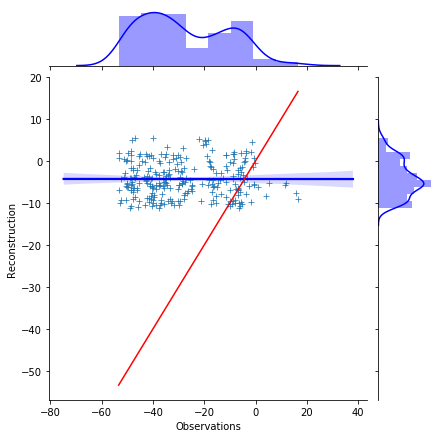

In [18]:
sns.jointplot(obs.T, predictions.T, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, predictions.T, marker='+')
sns.lineplot(obs.T, obs.T, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)
print("slope", slope, "r2_val", r_value)

#### Use the real observations and regress

In [20]:
robs_idx = ndf['matched_idx']
robs = (ndf['quantile'].values)/10.0 # fix units
reofs = vT[:4, robs_idx]

Compare the distributions of the station observations and of the models

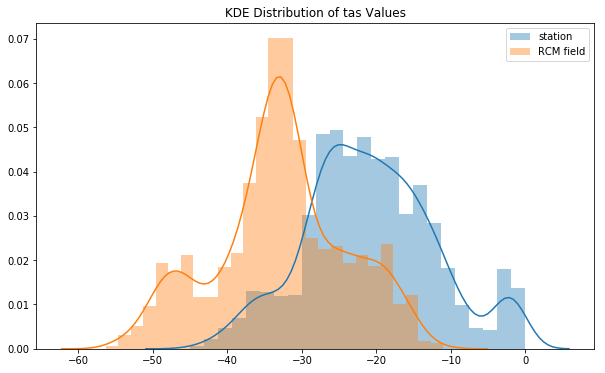

In [21]:
plt.figure(figsize=(10, 6))
plt.title('KDE Distribution of {} Values'.format(dv))
sns.distplot(robs, label='station')
sns.distplot(iens[0, robs_idx], label='RCM field')
plt.legend()

Fit the model and predict it

In [22]:
rmodel = fit_eof(reofs.T, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs.T)

Regressed model score: 0.38217714384865276 0.38217714384865276


slope 0.3821771438486524 r2_val 0.6182047750128208
Std deviation ratio of vectors: 1.8763562785874366


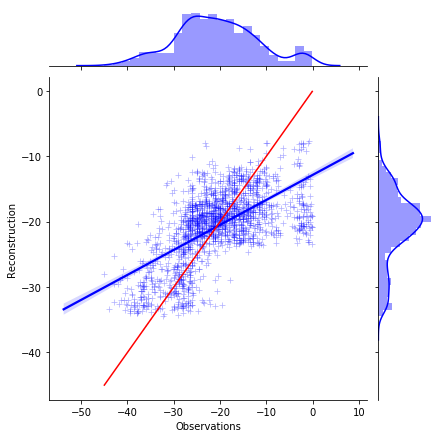

In [23]:

sns.jointplot(robs, linrpredictions, kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(robs, linrpredictions, 
                color="blue",
                marker='+',
                alpha=0.3)

sns.lineplot(robs.T, 
          robs.T,
          color='r',
            dashes=True)

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors:", np.mean(np.std(iens, axis=1))/np.std(robs))